In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df = yf.download('^GSPC', start='2010-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df['returns'] = np.log(df.Close.pct_change() + 1)

Calculating log returns
Log returns are additive over time. The log return over two days is simply the sum of the log returns for day 1 and day 2.

In [4]:
def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df['Lag_' + str(i)] = df['returns'].shift(i)
        names.append('Lag_' + str(i))
    return names

In [5]:
lagnames = lagit(df,5)

In [6]:
df.dropna(inplace=True)

In [7]:
model = LinearRegression()

In [8]:
model.fit(df[lagnames], df['returns'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
df['prediction'] = model.predict(df[lagnames])

In [10]:
# Define a trading threshold (e.g., 0.01% or 0.0001 as a decimal for log returns)
# This means we only trade if the predicted move is greater than this threshold
trade_threshold = 0.0001 # 0.01% predicted log return

In [11]:
df['direction'] = [1 if i > trade_threshold else (-1 if i < -trade_threshold else 0) for i in df.prediction]
# default 0 if no clear direction

In [12]:
df['strat'] = df['direction'] * df['returns']

In [13]:
np.exp(df[['returns', 'strat']].sum())

Price    Ticker
returns             5.273344
strat              10.829691
dtype: float64

<Axes: xlabel='Date'>

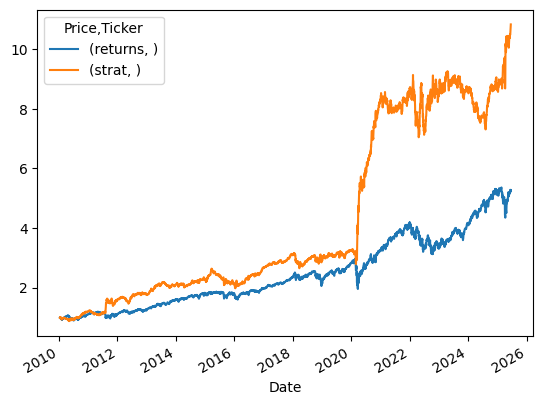

In [14]:
np.exp(df[['returns', 'strat']].cumsum()).plot()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Train-Test Split , common test set size 30%
train, test = train_test_split(df, shuffle=False,
                             test_size=0.3, random_state=0) # Changed from 0.7 to 0.2

In [17]:
model = LinearRegression()

In [18]:
model.fit(train[lagnames], train['returns'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
test['prediction'] = model.predict(test[lagnames])

In [20]:
test['direction'] = [1 if i > trade_threshold else (-1 if i < -trade_threshold else 0) for i in test.prediction]
# default 0 if no clear direction

In [21]:
test['strat'] = test['direction'] * test['returns']

In [22]:
total_market_return = np.exp(test['returns'].sum()) - 1

In [23]:
total_strategy_return = np.exp(test['strat'].sum()) - 1

In [24]:
print(f"\n--- Out-of-Sample Performance on Test Set ---")
print(f"Total Market (Buy & Hold) Return: {total_market_return:.2%}")
print(f"Total Strategy Return: {total_strategy_return:.2%}")


--- Out-of-Sample Performance on Test Set ---
Total Market (Buy & Hold) Return: 74.54%
Total Strategy Return: 23.72%


<Axes: xlabel='Date'>

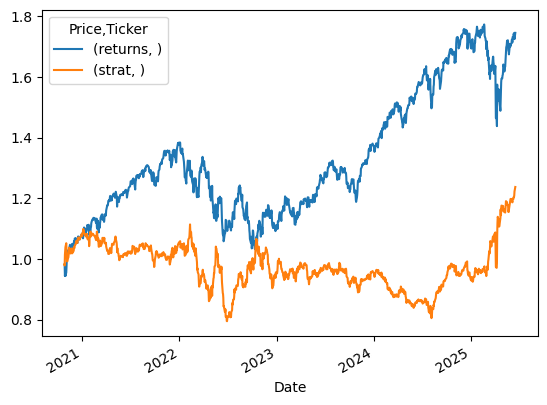

In [25]:
np.exp(test[['returns', 'strat']].cumsum()).plot()

In [26]:
(test['direction'].diff() !=0).value_counts()

direction
True     764
False    401
Name: count, dtype: int64